In [2]:
import torch
from pathlib import Path
import requests
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from typing import Tuple, Dict, List

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
import torch.nn as nn
class Identicycle(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(hidden_units),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(hidden_units),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units * 2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(hidden_units * 2),
            nn.Conv2d(hidden_units * 2, hidden_units * 2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(hidden_units * 2),
            nn.MaxPool2d(2)
        )
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(hidden_units * 2, hidden_units * 4, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(hidden_units * 4),
            nn.Conv2d(hidden_units * 4, hidden_units * 4, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(hidden_units * 4),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((4, 4)),
            nn.Flatten(),
            nn.Linear(hidden_units * 4 * 4 * 4, hidden_units * 4),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(hidden_units * 4),
            nn.Linear(hidden_units * 4, output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        x = self.classifier(x)
        return x
torch.manual_seed(42)

In [5]:
model_Test = Identicycle(input_shape=3, hidden_units=128, output_shape=7)
MODEL_PATH = Path("models")
MODEL_NAME = "3x3-3L-128N-200E-Model1"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

model_Test.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

model_Test = model_Test.to(device)

In [27]:
def classify_image(custom_image_path, model, class_names):
  custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)
  custom_image = custom_image / 255.
  custom_image_transform = transforms.Compose([
    transforms.Resize((128, 128)),
  ])
  custom_image_transformed = custom_image_transform(custom_image)
  model.eval()
  with torch.inference_mode():
    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)
    custom_image_pred = model(custom_image_transformed_with_batch_size.to(device))
  custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
  custom_image_pred_label = custom_image_pred_probs.argmax(dim=1)
  custom_image_pred_class = class_names[custom_image_pred_label.cpu()]
  custom_image_pred_confidence = custom_image_pred_probs[0][custom_image_pred_label]

  return custom_image_pred_class, custom_image_pred_confidence




In [55]:
import os
import torchvision
import json


def predict_images(data_path, model):
  image_paths = os.listdir(data_path)
  predictions = []
  for image_path in image_paths:
    if not image_path.endswith(".jpg"):
      continue
    real_image = data_path / image_path
    image = torchvision.io.read_image(str(real_image))
    pred_class, pred_confidence = classify_image(real_image, model, class_names)
    predictions.append((real_image, pred_class,pred_confidence.squeeze(dim=0)))
  return predictions


if __name__ == "__main__":
  model_Test
  class_names = ['ewaste', 'glass', 'metal', 'organic', 'paper', 'plastic', 'trash']

  data_path = Path("dataTest/trash")
  predictions = predict_images(data_path, model_Test)
  with open("trash.json", "w") as json_file:
    json_data = []
    for image_path, pred_class, pred_percentage in predictions:
      P = "percentage:%4.2f"% (pred_percentage)
      json_data.append({"image_path": image_path, "class": pred_class, "percentage": P})
      json_data = [{"image_path":str(image_path), "class":pred_class, "percentage":P}]
      json.dump(json_data, json_file)


In [12]:
data_path = Path("data_test")

custom_image_path = data_path / "a.jpg"

custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

print(f"Custom image tensor:\n{custom_image_uint8}\n")
print(f"Custom image shape: {custom_image_uint8.shape}\n")
print(f"Custom image dtype: {custom_image_uint8.dtype}")
custom_image_path

Custom image tensor:
tensor([[[254, 254, 254,  ..., 254, 254, 254],
         [254, 254, 254,  ..., 254, 254, 254],
         [254, 254, 254,  ..., 254, 254, 254],
         ...,
         [254, 254, 254,  ..., 254, 254, 254],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255]],

        [[254, 254, 254,  ..., 254, 254, 254],
         [254, 254, 254,  ..., 254, 254, 254],
         [254, 254, 254,  ..., 254, 254, 254],
         ...,
         [254, 254, 254,  ..., 254, 254, 254],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255]],

        [[254, 254, 254,  ..., 254, 254, 254],
         [254, 254, 254,  ..., 254, 254, 254],
         [254, 254, 254,  ..., 254, 254, 254],
         ...,
         [254, 254, 254,  ..., 254, 254, 254],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255]]], dtype=torch.uint8)

Custom image shape: torch.Size([3, 474, 474])

Custom image dtype

WindowsPath('data_test/a.jpg')

In [13]:
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

custom_image = custom_image / 255.

print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
         [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
         [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
         ...,
         [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
         [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
         [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
         ...,
         [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
         [0.9961, 0.9961, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
         [0.9961, 0.9961, 0.9961,  ..

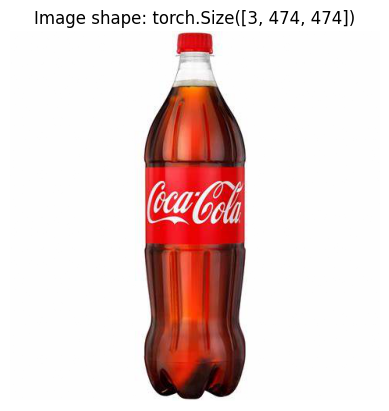

In [14]:
plt.imshow(custom_image.permute(1, 2, 0))
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);

In [15]:
custom_image_transform = transforms.Compose([
    transforms.Resize((128, 128)),
])
custom_image_transformed = custom_image_transform(custom_image)

print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 474, 474])
New shape: torch.Size([3, 128, 128])


In [16]:
model_Test.eval()
with torch.inference_mode():
    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)

    print(f"Custom image transformed shape: {custom_image_transformed.shape}")
    print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")

    custom_image_pred = model_Test(custom_image_transformed.unsqueeze(dim=0).to(device))

Custom image transformed shape: torch.Size([3, 128, 128])
Unsqueezed custom image shape: torch.Size([1, 3, 128, 128])


In [17]:
custom_image_pred

tensor([[-0.6766,  5.6163, -5.7489, -2.2616, -7.9245, 14.3607, -9.6053]],
       device='cuda:0')

In [18]:
print(f"Prediction logits: {custom_image_pred}")

custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

Prediction logits: tensor([[-0.6766,  5.6163, -5.7489, -2.2616, -7.9245, 14.3607, -9.6053]],
       device='cuda:0')
Prediction probabilities: tensor([[2.9467e-07, 1.5932e-04, 1.8470e-09, 6.0393e-08, 2.0970e-10, 9.9984e-01,
         3.9053e-11]], device='cuda:0')
Prediction label: tensor([5], device='cuda:0')


In [19]:
class_names = ['ewaste', 'glass', 'metal', 'organic', 'paper', 'plastic', 'trash']
custom_image_pred_class = class_names[custom_image_pred_label.cpu()]
custom_image_pred_class

'plastic'

In [20]:
custom_image_pred_probs

tensor([[2.9467e-07, 1.5932e-04, 1.8470e-09, 6.0393e-08, 2.0970e-10, 9.9984e-01,
         3.9053e-11]], device='cuda:0')

In [21]:
custom_image_pred_label.squeeze(dim=0)

tensor(5, device='cuda:0')

In [22]:
for (porcentage,labels) in zip(custom_image_pred_probs.squeeze(dim=0),class_names):
  s = "porcentage:  %8.2f"% (porcentage)
  print(s,labels)

porcentage:      0.00 ewaste
porcentage:      0.00 glass
porcentage:      0.00 metal
porcentage:      0.00 organic
porcentage:      0.00 paper
porcentage:      1.00 plastic
porcentage:      0.00 trash


In [23]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""

    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
    target_image = target_image / 255.
    if transform:
        target_image = transform(target_image)
    model.to(device)
    model.eval()
    with torch.inference_mode():
        target_image = target_image.unsqueeze(dim=0)
        target_image_pred = model(target_image.to(device))
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    plt.imshow(target_image.squeeze().permute(1, 2, 0))
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

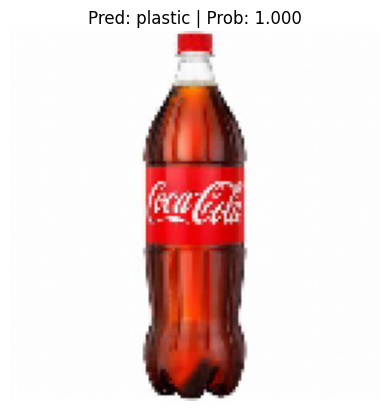

In [24]:
pred_and_plot_image(model=model_Test,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)